# Data

The data necessary to answer the problem statement includes the **locations and the types of venues** around the Toronto city area. 

First, the **locations of all existing laundromats or laundry services in the Toronto city region** will be extracted to survey the competition. Ideally, the new laundromat would be set up at a certain distance away from other existing laundromats. 
Secondly, the **locations of travel accommodations** such as hotels, hostels and motels in the region will be obtained. This is to estimate the amount of visitors that would frequent the laundromat, based on the assumption that the clientele of the laundromat would be mainly made up of travellers. 

A suitable location for the new laundromat would be at the centre of a cluster of hotels and hostels so as to maximise the business potential. A *clustering algorithm* would be performed on the locations of laundromats and hotels separately to find the concentration of both types of the establishments. 

Finally, the ideal location for setting up a new laundromat can be inferred based on the clustering result. 


## 1. Create *pandas* dataframe of Neighborhoods in Toronto

## Importing necessary libraries

In [4]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

## Extracting the html file from the URL of postal codes of Canada

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url).text

## Using BeautifulSoup to find the table rows containing the postcode info

In [6]:
soup = BeautifulSoup(r,'lxml')
btable = soup.find('table')
tab_rows = btable.find_all('tr')

## Creating the pandas dataframe and populating it with info from the html 
### (with processing of _Not assigned_ and duplicate postal code rows)

In [7]:
column_names = ['PostalCode', 'Borough', 'Neighborhood']  # Setting the columns for the new pandas dataframe
postcodes = pd.DataFrame(columns=column_names)

for n in range(1,len(tab_rows)):
    row_t = tab_rows[n].text.split('\n')
    if row_t[2] != 'Not assigned':  # Skip rows with 'Not assigned' Boroughs
        if row_t[3] == 'Not assigned':  # Copying Borough name to 'Not assigned' Neighborhoods
            row_t[3] = row_t[2]
        if row_t[1] in postcodes.loc[:,'PostalCode'].unique():  # Appending the Neighborhood names to duplicate PostalCode areas
            postcodes.loc[tag,'Neighborhood'] = postcodes.loc[tag,'Neighborhood'] + ', ' + row_t[3]
        else: 
            postcodes.loc[n,:] = row_t[1:4]
            tag = n

postcodes.reset_index(drop=True,inplace=True)
postcodes.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


## Print the number of rows of the dataframe

In [8]:
print('The shape of the dataframe: ',postcodes.shape)

The shape of the dataframe:  (103, 3)


## Downloading csv file that has the geographical coordinates of each postal code 
## *(Geocoder package failed to work)*

In [9]:
import csv

!wget -q -O Geospatial_Coordinates.csv http://cocl.us/Geospatial_data
print('Data downloaded!')

# read csv file
coord = pd.read_csv('Geospatial_Coordinates.csv')
coord.head()

Data downloaded!


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Match the Postal Codes to the coordinate values to populate the dataframe

In [10]:
for i,n in enumerate(postcodes['PostalCode']):
    res = coord[coord['Postal Code']==n]
    postcodes.loc[i,'Latitude'] = res.Latitude.values
    postcodes.loc[i,'Longitude'] = res.Longitude.values

postcodes.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


## Exploring only neighborhoods in the burough of Central Toronto

In [11]:
central_toronto = postcodes[postcodes['Borough']=='Central Toronto'].reset_index(drop=True)
central_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
5,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
6,M4S,Central Toronto,Davisville,43.704324,-79.388790
7,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
8,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


## 2. Search for laundromats in the neighborhood of Central Toronto

In [12]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import numpy as np
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    mkl_fft-1.0.6              |           py36_0         586 KB  conda-forge
    mkl_random-1.0.2           |           py36_0         1.3 MB  conda-forge
    mkl-2018.0.3               |                1       198.7 MB
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    numpy-1.15.0               |   py36h1b885b7_0          35 KB
    branca-0.3.1               |             py_0          25 KB  conda-forge
    numpy-base-1.15.0          |   py3

## Define Foursquare credentials and version

In [13]:
CLIENT_ID = 'NHZOV5ISEMB3VWNLRUAQHL2DS4UIEWBROQXV0JYRWKHFV5XS' # your Foursquare ID
CLIENT_SECRET = '0LU1L02OT50RRR1GCA2KX01H0ENR2E2ZL132QX1GR5RFMKQF' # your Foursquare Secret
VERSION = '20181111' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NHZOV5ISEMB3VWNLRUAQHL2DS4UIEWBROQXV0JYRWKHFV5XS
CLIENT_SECRET:0LU1L02OT50RRR1GCA2KX01H0ENR2E2ZL132QX1GR5RFMKQF


## Define getNearbyLaundryVenues function for extracting Laundromat venues

In [14]:
def getNearbyLaundryVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            'Laundromat Laundry',
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Select a subset of neighborhoods and explore the nearby laundromats for each

In [33]:
laundro_venues = getNearbyLaundryVenues(central_toronto['Neighborhood'],central_toronto["Latitude"],central_toronto['Longitude'],2000)
laundro_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Maytag Laundry Linens And Gifts,43.730241,-79.403576,Laundry Service
1,Roselawn,43.711695,-79.416936,Royal Forest Coin Laundry,43.701115,-79.425177,Laundry Service
2,Roselawn,43.711695,-79.416936,Bathurst Street Coin Laundry,43.723356,-79.430118,Laundry Service
3,Roselawn,43.711695,-79.416936,Magic Touch Coin Laundry,43.728324,-79.431799,Laundry Service
4,Roselawn,43.711695,-79.416936,Coin Laundry,43.724148,-79.430481,Laundry Service


## 3. Search for hotels, hostels and motels in the neighborhood of Toronto

## Define getNearbyHotelVenues function for extracting Hotel venues

In [16]:
def getNearbyHotelVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            'Hostel Hotel',
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
hotel_venues = getNearbyHotelVenues(central_toronto['Neighborhood'],central_toronto["Latitude"],central_toronto['Longitude'],2000)
hotel_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
1,Lawrence Park,43.728020,-79.388790,Hotel Wibke,43.707730,-79.395858,Speakeasy
2,Lawrence Park,43.728020,-79.388790,Skyline Hotels & Resorts,43.707578,-79.395640,Office
3,Roselawn,43.711695,-79.416936,Hotel Gelato,43.703478,-79.414311,Café
4,Roselawn,43.711695,-79.416936,Hotel Wibke,43.707730,-79.395858,Speakeasy


## 4. Perform hierarchical clustering on laundromat and hotel locations in Central Toronto

### Generate Folium map (assuming Toronto city hall as the centre of Toronto) to show the locations of laundromats and hotels

In [18]:
# Assuming Toronto coordinates as 43.653170, -79.383541
tor_latitude = 43.653170
tor_longitude = -79.383541

# create map
map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(laundro_venues['Venue Latitude'], laundro_venues['Venue Longitude'], laundro_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lon, poi in zip(hotel_venues['Venue Latitude'], hotel_venues['Venue Longitude'], hotel_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Tabulate coordinates of laundromats and hotels

In [19]:
laundro_feature = laundro_venues[['Venue Latitude','Venue Longitude']]
hotel_feature = hotel_venues[['Venue Latitude','Venue Longitude']]

### Perform hierarchical clustering to group nearby laundromats and hotels

In [20]:
from sklearn.preprocessing import MinMaxScaler
laundro_data = laundro_feature.values #returns a numpy array
hotel_data = hotel_feature.values
min_max_scaler = MinMaxScaler()
laundro_mtx = min_max_scaler.fit_transform(laundro_data)
hotel_mtx = min_max_scaler.fit_transform(hotel_data)
laundro_mtx [0:5]

array([[1.        , 0.3904177 ],
       [0.6288908 , 0.09697779],
       [0.91227002, 0.02986149],
       [0.9755706 , 0.00701739],
       [0.9223651 , 0.02492547]])

In [21]:
import scipy
laundro_leng = laundro_mtx.shape[0]
laundro_D = scipy.zeros([laundro_leng,laundro_leng])
for i in range(laundro_leng):
    for j in range(laundro_leng):
        laundro_D[i,j] = scipy.spatial.distance.euclidean(laundro_mtx[i], laundro_mtx[j])
        
print(laundro_D)

[[0.         0.47310571 0.3710759  ... 0.37579332 0.77721087 0.8358833 ]
 [0.47310571 0.         0.29121879 ... 0.49889405 0.42528853 0.7289435 ]
 [0.3710759  0.29121879 0.         ... 0.60775833 0.71454066 0.96253584]
 ...
 [0.37579332 0.49889405 0.60775833 ... 0.         0.56121957 0.47154443]
 [0.77721087 0.42528853 0.71454066 ... 0.56121957 0.         0.44788785]
 [0.8358833  0.7289435  0.96253584 ... 0.47154443 0.44788785 0.        ]]


In [22]:
# Import libraries
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
import pylab
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster

# Perform clustering
laundro_Z = hierarchy.linkage(laundro_D, 'complete')
max_d = 3
laundro_clusters = fcluster(laundro_Z, max_d, criterion='distance')
laundro_dend = hierarchy.dendrogram(laundro_Z)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


In [23]:
hotel_leng = hotel_mtx.shape[0]
hotel_D = scipy.zeros([hotel_leng,hotel_leng])
for i in range(hotel_leng):
    for j in range(hotel_leng):
        hotel_D[i,j] = scipy.spatial.distance.euclidean(hotel_mtx[i], hotel_mtx[j])
        
print(hotel_D)

[[0.         0.11496622 0.11058236 ... 0.7590232  0.65807007 0.64457599]
 [0.11496622 0.         0.00561036 ... 0.70466877 0.63874749 0.63880283]
 [0.11058236 0.00561036 0.         ... 0.70337434 0.63570043 0.63521127]
 ...
 [0.7590232  0.70466877 0.70337434 ... 0.         0.23710913 0.31381699]
 [0.65807007 0.63874749 0.63570043 ... 0.23710913 0.         0.07677343]
 [0.64457599 0.63880283 0.63521127 ... 0.31381699 0.07677343 0.        ]]


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


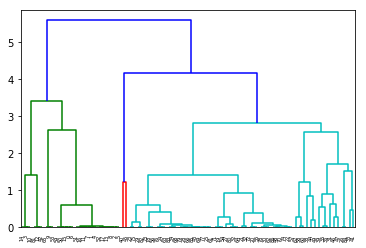

In [24]:
# Perform clustering
hotel_Z = hierarchy.linkage(hotel_D, 'complete')
max_d = 3
hotel_clusters = fcluster(hotel_Z, max_d, criterion='distance')
hotel_dend = hierarchy.dendrogram(hotel_Z)

## 5. Find suitable location for new laundromat 

### Append the cluster numbers to the laundromat and hotel dataframes

In [25]:
laundro_venues['cluster_'] = laundro_clusters
hotel_venues['cluster_'] = hotel_clusters

### Generate a Folium map to illustrate the clusters of laundromats and hotels (reds: Laundromats, blues: Hotels)

In [26]:
# Assuming Toronto coordinates as 43.653170, -79.383541
tor_latitude = 43.653170
tor_longitude = -79.383541

# create map
map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# set color scheme for the laundromat clusters
laundro_kclusters = laundro_clusters.max()
x = np.arange(laundro_kclusters)
ys = [i+x+(i*x)**2 for i in range(laundro_kclusters)]
colors_array = cm.rainbow(np.linspace(0.8, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(laundro_venues['Venue Latitude'], laundro_venues['Venue Longitude'], laundro_venues['Venue'], laundro_venues['cluster_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# set color scheme for the hotel clusters
hotel_kclusters = hotel_clusters.max()
x = np.arange(hotel_kclusters)
ys = [i+x+(i*x)**2 for i in range(hotel_kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 0.3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotel_venues['Venue Latitude'], hotel_venues['Venue Longitude'], hotel_venues['Venue'], hotel_venues['cluster_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Extracting the coordinate of cluster centers for better visualisation of laundromat and hotel hotspots around Central Toronto

In [27]:
laundro_mean = pd.DataFrame(columns=['Venue Latitude','Venue Longitude'])
laundro_count = pd.DataFrame(columns=['Number of Venues'])
hotel_mean = pd.DataFrame(columns=['Venue Latitude','Venue Longitude'])
hotel_count = pd.DataFrame(columns=['Number of Venues'])

for i in range(1,laundro_kclusters+1):
    laundro_mean.loc[i-1,:]=laundro_venues[laundro_venues['cluster_']==i][['Venue Latitude','Venue Longitude']].mean()
    laundro_count.loc[i-1] = laundro_venues[laundro_venues['cluster_']==i]['cluster_'].count()

for i in range(1,hotel_kclusters+1):
    hotel_mean.loc[i-1,:]=hotel_venues[hotel_venues['cluster_']==i][['Venue Latitude','Venue Longitude']].mean()
    hotel_count.loc[i-1] = hotel_venues[hotel_venues['cluster_']==i]['cluster_'].count()
    
laundro_mean = pd.concat([laundro_mean, laundro_count], axis=1, sort=False)
hotel_mean = pd.concat([hotel_mean, hotel_count], axis=1, sort=False)
print('Laundromat clusters: \n',laundro_mean)
print('Hotel clusters: \n',hotel_mean)

Laundromat clusters: 
   Venue Latitude Venue Longitude Number of Venues
0        43.7271        -79.4236               11
1         43.705        -79.3884               12
2        43.6688        -79.3786               11
3        43.6872        -79.4246               16
4        43.6704        -79.4061               56
Hotel clusters: 
   Venue Latitude Venue Longitude Number of Venues
0        43.6959        -79.4155                6
1        43.7075        -79.3911               20
2         43.656        -79.4106                2
3        43.6681        -79.3914               59


### Generating Folium map with showing laundromat and hotel clusters, with larger circles representing a higher concentration of venues 
### (Reds: Laundromats, Blues: Hotels)

In [28]:
# Assuming Toronto coordinates as 43.653170, -79.383541
tor_latitude = 43.653170
tor_longitude = -79.383541

# create map
map_center_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# set color scheme for the laundromat clusters
laundro_kclusters = laundro_clusters.max()
x = np.arange(laundro_kclusters)
ys = [i+x+(i*x)**2 for i in range(laundro_kclusters)]
colors_array = cm.rainbow(np.linspace(0.8, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
scale_laundry = laundro_mean['Number of Venues'].max()
for lat, lon, clustsize, clustnum in zip(laundro_mean['Venue Latitude'], laundro_mean['Venue Longitude'], laundro_mean['Number of Venues'],laundro_mean.index):
    label = folium.Popup(' Laundromat Cluster ' + str(clustnum+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=clustsize/scale_laundry*30,
        popup=label,
        color=rainbow[clustnum],
        fill=True,
        fill_color=rainbow[clustnum],
        fill_opacity=0.7).add_to(map_center_clusters)
    
# set color scheme for the hotel clusters
hotel_kclusters = hotel_clusters.max()
x = np.arange(hotel_kclusters)
ys = [i+x+(i*x)**2 for i in range(hotel_kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 0.3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
scale_hotel = hotel_mean['Number of Venues'].max()
for lat, lon, clustsize, clustnum in zip(hotel_mean['Venue Latitude'], hotel_mean['Venue Longitude'], hotel_mean['Number of Venues'], hotel_mean.index):
    label = folium.Popup(' Hotel Cluster ' + str(clustnum+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=clustsize/scale_hotel*30,
        popup=label,
        color=rainbow[clustnum],
        fill=True,
        fill_color=rainbow[clustnum],
        fill_opacity=0.7).add_to(map_center_clusters)
       
map_center_clusters